In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread, imshow
import pickle
import glob
import pandas as pd
import cv2
import random 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import LinearSVC
import time

In [7]:
################### Loading the dataset and Randomly selecting 10 million samples ###################################
path_dataset =  r"dataset\\"
path_labels =  r"masks\\" 

df_dataset = []

for image in os.listdir(path_dataset):
    df = pd.DataFrame()
    img = cv2.imread(path_dataset + image)
    msk =  cv2.threshold(cv2.imread(path_labels + image,0), 0, 1, cv2.THRESH_BINARY)[1]
    df["B_Pixel_Values"] = img[:,:,0].reshape(-1).astype("uint8")
    df["G_Pixel_Values"] = img[:,:,1].reshape(-1).astype("uint8")
    df["R_Pixel_Values"] = img[:,:,2].reshape(-1).astype("uint8")
    df["Label_Values"] = msk.reshape(-1).astype("uint8")
    df_dataset.append(df)
    
df_dataset = pd.concat(df_dataset,axis=0, ignore_index=True)
print("dataset has been loaded")


DATAFRAME= df_dataset.sample(n=10000000, random_state=1)
Y = DATAFRAME["Label_Values"].values
X = DATAFRAME[['B_Pixel_Values','G_Pixel_Values', 'R_Pixel_Values']].values
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size = 0.2, random_state=42, shuffle=False)

In [ ]:
##################### NEURAL NETWORK ###########################
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 50, 50, 20), random_state=1, shuffle=True)
model.fit(X_train, y_train)
filename = '10M-seagrass_NN20505020'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
############################ XGboost  ###########################
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
######################## Random Forest  ###########################
model = RandomForestClassifier (n_estimators = 100, n_jobs = -1, random_state=42)
model.fit(X_train, y_train)
filename = '10M-seagrass_RandomForest'
pickle.dump(model, open(filename, 'wb'))
prediction_test = model.predict(X_test)
print("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

In [ ]:
###################### SVM #######################################
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)
model = LinearSVC(max_iter=10000)
model.fit(X_train, y_train)
filename = "10M-seagrass_SVM_10000"
pickle.dump(model,open(filename,'wb'))
prediction_test = model.predict(X_test)
print("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

In [30]:
# Parameter tuning for postprocessing
# Model has already been trianed on 10 million randomly selected from the whole dataset
# After running the following codes, final results showed that the average accuracy for 10 selected image after postprocessing was less than the average accuracy for original predictions: Therefore we did not use postprocessing for ML-classifiers predictions

filename = "10M-100-es-seagrass_RandomForest"
# filename = "10M-seagrass_NN20505020"
# filename = "10M-seagrass_SVM_10000"
# filename = "10M-100es-seagrass_XGboost"

model = pickle.load(open(filename, 'rb'))

#loading calibration dataset and related labels (for 10 randomly selected images)
path_dataset_calib =  r"tunning\calib\dataset\\"
path_labels_calib =  r"tunning\calib\labels\\" 
acc_postpro = {} 
acc_org = {} 
kernel_sizes = [(3,3),(5,5),(7,7),(9,9),(11,11),(13,13),(15,15),(17,17),(19,19),(21,21)]
for image in os.listdir(path_dataset_calib):
    start_time = time.time()
    df=pd.DataFrame()
    img = cv2.imread(path_dataset_calib + image)
    msk =  cv2.threshold(cv2.imread(path_labels_calib + image,0), 0, 1, cv2.THRESH_BINARY)[1]
    df["B_Pixel_Values"] = img[:,:,0].reshape(-1).astype("uint8")
    df["G_Pixel_Values"] = img[:,:,1].reshape(-1).astype("uint8")
    df["R_Pixel_Values"] = img[:,:,2].reshape(-1).astype("uint8")
    df["Label_Values"] = msk.reshape(-1).astype("uint8")
    X = df[['B_Pixel_Values','G_Pixel_Values', 'R_Pixel_Values']].values
    y = df["Label_Values"].values
    
    # predict on the selected image and save the accuracy
    prediction_org = model.predict(X)
    
    acc_org.update({image: metrics.accuracy_score(y, prediction_org)})
    acc_k_dict = {}
    for k in kernel_sizes:
        
        acc = []
        erosion = cv2.erode(prediction_org.reshape((msk.shape)),np.ones(k,np.uint8))
        acc.append(metrics.accuracy_score(y, erosion.reshape(-1)))

        dilate = cv2.dilate(prediction_org.reshape((msk.shape)), np.ones(k,np.uint8))
        acc.append(metrics.accuracy_score(y, dilate.reshape(-1)))

        erosion_dilate = cv2.dilate(erosion, np.ones(k,np.uint8))
        acc.append(metrics.accuracy_score(y, erosion_dilate.reshape(-1)))
        
        dilate_erosion = cv2.erode(dilate, np.ones(k,np.uint8))
        acc.append(metrics.accuracy_score(y, dilate_erosion.reshape(-1)))
        
        acc_k_dict.update({k: acc})

        acc_postpro.update({image: acc_k_dict})
    print("--- %s seconds --- ==> for " % (time.time() - start_time)+image)

--- 40.17455315589905 seconds --- ==> for DJI_0010.jpg
--- 40.5141065120697 seconds --- ==> for DJI_0029.jpg
--- 40.12346839904785 seconds --- ==> for DJI_0051.jpg
--- 39.80156850814819 seconds --- ==> for DJI_0070.jpg
--- 38.757620334625244 seconds --- ==> for DJI_0075.jpg
--- 39.18144416809082 seconds --- ==> for DJI_0094.jpg
--- 39.04865908622742 seconds --- ==> for DJI_0118.jpg
--- 39.89578104019165 seconds --- ==> for DJI_0151.jpg
--- 39.59541583061218 seconds --- ==> for DJI_0177.jpg
--- 39.30926179885864 seconds --- ==> for DJI_0261.jpg


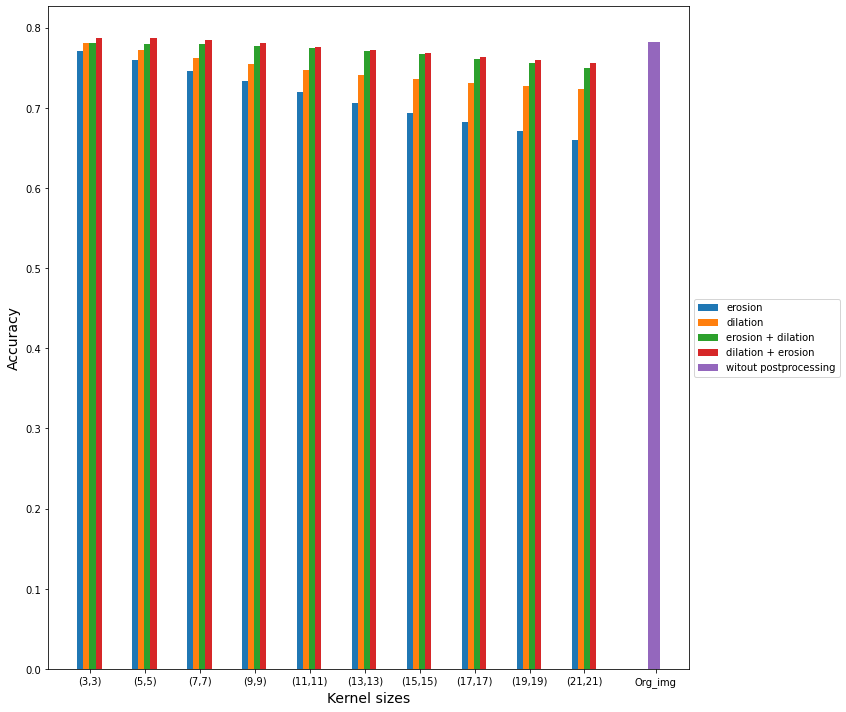

<function print>

In [31]:
acc_post_av = {}
for k in kernel_sizes:
    sum_0=sum_1=sum_2=sum_3= 0
    for image in os.listdir(path_dataset_calib):
        sum_0 += acc_postpro[image][k][0]
        sum_1 += acc_postpro[image][k][1]
        sum_2 += acc_postpro[image][k][2]
        sum_3 += acc_postpro[image][k][3]
    acc_post_av.update({k: list((sum_0/10,sum_1/10,sum_2/10,sum_3/10))})

acc_org_av = sum(acc_org.values())/10

kernels = ['(3,3)','(5,5)','(7,7)','(9,9)','(11,11)','(13,13)','(15,15)','(17,17)','(19,19)','(21,21)', 'Org_img']
e = [acc_post_av [k][0] for k in kernel_sizes]
d =  [acc_post_av [k][1] for k in kernel_sizes]
e_d = [acc_post_av [k][2] for k in kernel_sizes]
d_e = [acc_post_av [k][3] for k in kernel_sizes]
e.append(0)
d.append(0)
e_d.append(0)
d_e.append(0)
x_axis = np.arange(len(kernels))
width = 1/9
fig, ax = plt.subplots(1,1,figsize = (12,10))
ax.bar(x_axis+2*width, e, width, label = 'erosion')
ax.bar(x_axis+3*width, d, width, label = 'dilation')
ax.bar(x_axis+4*width, e_d, width, label = 'erosion + dilation')
ax.bar(x_axis+5*width, d_e, width, label = 'dilation + erosion')
ax.bar(x_axis+6*width, [0,0,0,0,0,0,0,0,0,0,acc_org_av], width*2, label = 'witout postprocessing')
ax.set_xticks([0.4,1.4,2.4,3.4,4.4,5.4,6.4,7.4,8.4,9.4,10.7],kernels)
ax.set_xlabel("Kernel sizes", fontsize = 14)
ax.set_ylabel("Accuracy", fontsize = 14)
ax.legend()
fig.tight_layout()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [156]:
# Predicting using RandomForest model, creating a csv file to show number of seagrass pixels in each image, and computing the average accuracy
path_dataset = r"dataset\\"
path_labels = r"masks\\" 
path_pred = r"preds (RANDOM_FOREST)\\"

filename = "10M-100-es-seagrass_RandomForest"
model = pickle.load(open(filename, 'rb'))
Results = []
for image in os.listdir(path_dataset):
    start_time = time.time()
    df=pd.DataFrame()
    img = cv2.imread(path_dataset + image)
    msk =  cv2.threshold(cv2.imread(path_labels + image,0), 0, 1, cv2.THRESH_BINARY)[1]
    df["B_Pixel_Values"] = img[:,:,0].reshape(-1).astype("uint8")
    df["G_Pixel_Values"] = img[:,:,1].reshape(-1).astype("uint8")
    df["R_Pixel_Values"] = img[:,:,2].reshape(-1).astype("uint8")
    df["Label_Values"] = msk.reshape(-1).astype("uint8")
    X = df[['B_Pixel_Values','G_Pixel_Values', 'R_Pixel_Values']].values
    y = df["Label_Values"].values
    y_pred = model.predict(X)
    Df=pd.DataFrame()
    Df["name"] = [image]
    Df["accuracy"] = [metrics.accuracy_score(y, y_pred)]
    Df["pixels"] = [msk.shape[0]*msk.shape[1]-y_pred.sum()]
    cv2.imwrite(path_pred+image,y_pred.reshape(msk.shape)*255)
    Results.append(Df)
    # print("--- %s seconds --- ==> for " % (time.time() - start_time)+image)
# print("making the dataframe to create csv file ...")
DataFrame = pd.concat(Results,axis=0, ignore_index=True)
# print("the dataframe has been created")
DataFrame.to_csv("SeagrassClassification.csv")
print("DONE")

DONE


In [160]:
#Average accuracy on the whole predictions
DataFrame["accuracy"].values.sum()/308

0.7507015393613768

Accuracy =  0.7421404677654


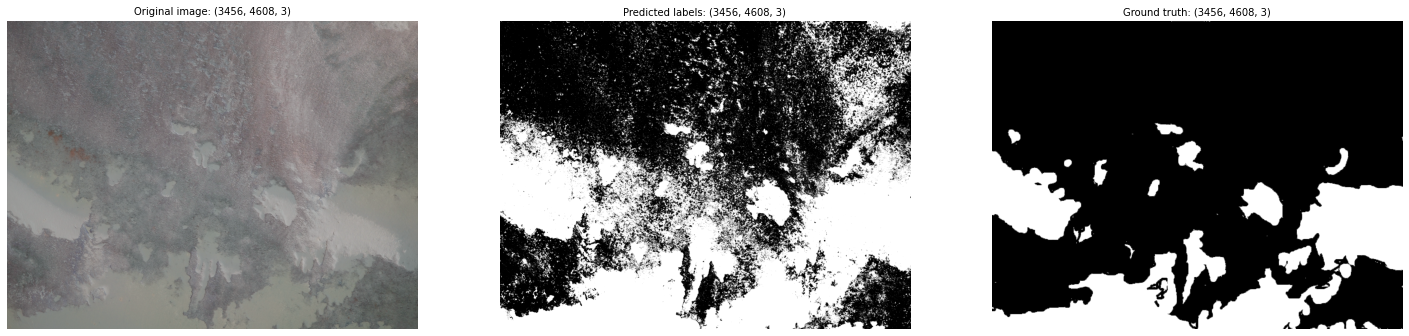

In [3]:
# Predicting on an image from dataset, showing the results, and computing the accuracy
filename = "10M-100-es-seagrass_RandomForest"
model = pickle.load(open(filename, 'rb'))
path_dataset = r"dataset\\"
path_labels = r"masks\\" 
df = pd.DataFrame()
img = cv2.imread(path_dataset + 'DJI_0028.jpg')
msk =  cv2.threshold(cv2.imread(path_labels + 'DJI_0028.jpg',0), 0, 1, cv2.THRESH_BINARY)[1]
df["B_Pixel_Values"] = img[:,:,0].reshape(-1).astype("uint8")
df["G_Pixel_Values"] = img[:,:,1].reshape(-1).astype("uint8")
df["R_Pixel_Values"] = img[:,:,2].reshape(-1).astype("uint8")
df["Label_Values"] = msk.reshape(-1).astype("uint8")
X1 = df[['B_Pixel_Values','G_Pixel_Values', 'R_Pixel_Values']].values
Y1 = df["Label_Values"].values
prediction_test = model.predict(X1)
print("Accuracy = ", metrics.accuracy_score(Y1, prediction_test))

fig = plt.figure(figsize=(25, 17))
rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)
plt.title("Original image: "+str(img.shape), fontsize=10)
plt.axis('off')
plt.imshow(img,"gray", vmin=0, vmax=255)
fig.add_subplot(rows, columns, 2)
plt.title("Predicted labels: "+str(img.shape), fontsize=10)
plt.axis('off')
plt.imshow(prediction_test.reshape((img[:,:,0].shape)), cmap = 'gray')
fig.add_subplot(rows, columns, 3)
plt.title("Ground truth: "+str(img.shape), fontsize=10)
plt.axis('off')
plt.imshow(msk, cmap = 'gray')

In [ ]:
# The following shows a bunch of codes that I used for preparing the dataset (such as renaming, rotating, and so on).

In [ ]:
# folder = r'C:\Users\shei972\Desktop\Marine\dataset\\'
# count=1
# for filename in os.listdir(folder):
#     source = folder+filename
#     destination = folder+"DJI_"+str(count).zfill(4)+".jpg"
#     os.rename(source, destination)
#     count+=1

In [ ]:
# folder = r'C:\Users\shei972\Desktop\Marine\sandspit_100m\100m\\'
# count=110
# for filename in os.listdir(folder):
#     source = folder+filename
#     destination = folder+"DJI_"+str(count).zfill(4)+".jpg"
#     os.rename(source, destination)
#     count+=1

In [ ]:
# path_labels =  r"C:\Users\shei972\Desktop\Seagrass dataset\labels\\"   
# for mask in os.listdir(path_labels):
#     msk = cv2.imread(path_labels + mask,0)
#     cv2.imwrite(mask.replace('.png','.jpg'), msk)

In [ ]:
# path_dataset =  r"C:\Users\shei972\Desktop\Seagrass dataset\dataset\\"
# path_labels =  r"C:\Users\shei972\Desktop\Seagrass dataset\masks\\"   
# rotation_options = (cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE)
# for image in os.listdir(path_dataset):
#     img = cv2.imread(path_dataset + image)
#     msk = cv2.imread(path_labels + image)
#     i = random.randint(1, 10)
#     if i>=5:
#         rotation = random.choice(rotation_options)
#         img = cv2.rotate(img, rotation)
#         msk = cv2.rotate(msk, rotation)
#         cv2.imwrite(path_dataset + image, img)
#         cv2.imwrite(path_labels  + image, msk)

In [ ]:
# path_dataset =  r"C:\Users\shei972\Desktop\Seagrass dataset\dataset\\"
# path_labels =  r"C:\Users\shei972\Desktop\Seagrass dataset\masks\\" 
# for image in os.listdir(path_dataset):
#     start_time = time.time()
#     img = cv2.imread(path_dataset + image)
#     msk = cv2.imread(path_labels + image)
#     if img.shape==(4608, 3456, 3):
#         img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
#         msk = cv2.rotate(msk, cv2.ROTATE_90_COUNTERCLOCKWISE)
#     cv2.imwrite(r"C:\Users\shei972\Desktop\U_NET\dataset\\" + image, img)
#     cv2.imwrite(r"C:\Users\shei972\Desktop\U_NET\masks\\"  + image, msk)